In [250]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV


from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, roc_auc_score

In [251]:
columns='fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class'

In [252]:
dataset = pd.read_csv('magic04.data', delimiter=',',names=columns)

In [253]:
dataset.shape

(19020, 11)

In [254]:
dataset.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [15]:
dataset.dtypes

fLength     float64
fWidth      float64
fSize       float64
fConc       float64
fConc1      float64
fAsym       float64
fM3Long     float64
fM3Trans    float64
fAlpha      float64
fDist       float64
class        object
dtype: object

In [16]:
dataset.nunique()

fLength     18643
fWidth      18200
fSize        7228
fConc        6410
fConc1       4421
fAsym       18704
fM3Long     18693
fM3Trans    18390
fAlpha      17981
fDist       18437
class           2
dtype: int64

In [17]:
dataset.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [95]:
target = dataset['class']
dataset= dataset.drop(['class'],axis=1)

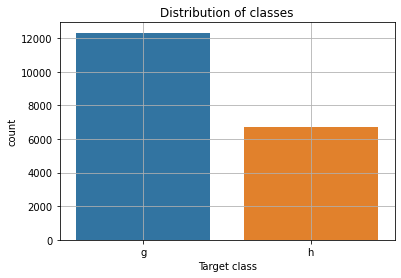

In [53]:
#Class distibution
sns.countplot(x=target)
plt.title("Distribution of classes")
plt.xlabel("Target class")
plt.grid()

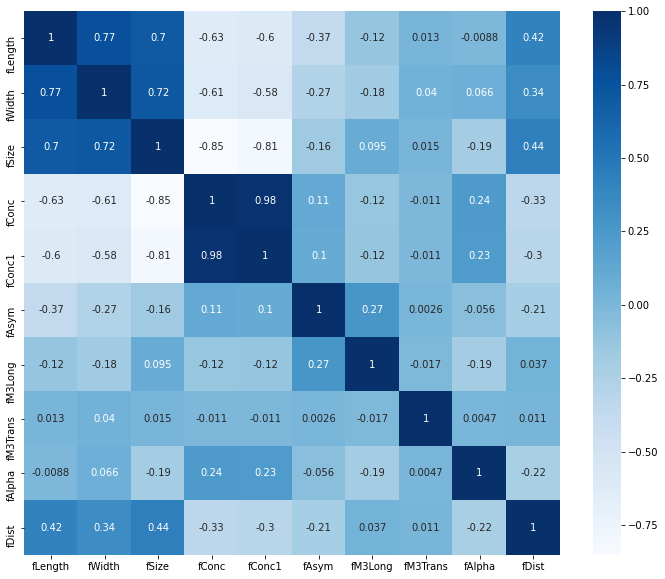

In [255]:
# Feature correlation
plt.figure(figsize=(12,10))
cor=dataset.corr()
sns.heatmap(cor,annot=True ,cmap=plt.cm.Blues)
plt.show()

In [112]:
# fconc and fconc1 are highly correlated
dataset= dataset.drop(['fConc1'],axis=1)

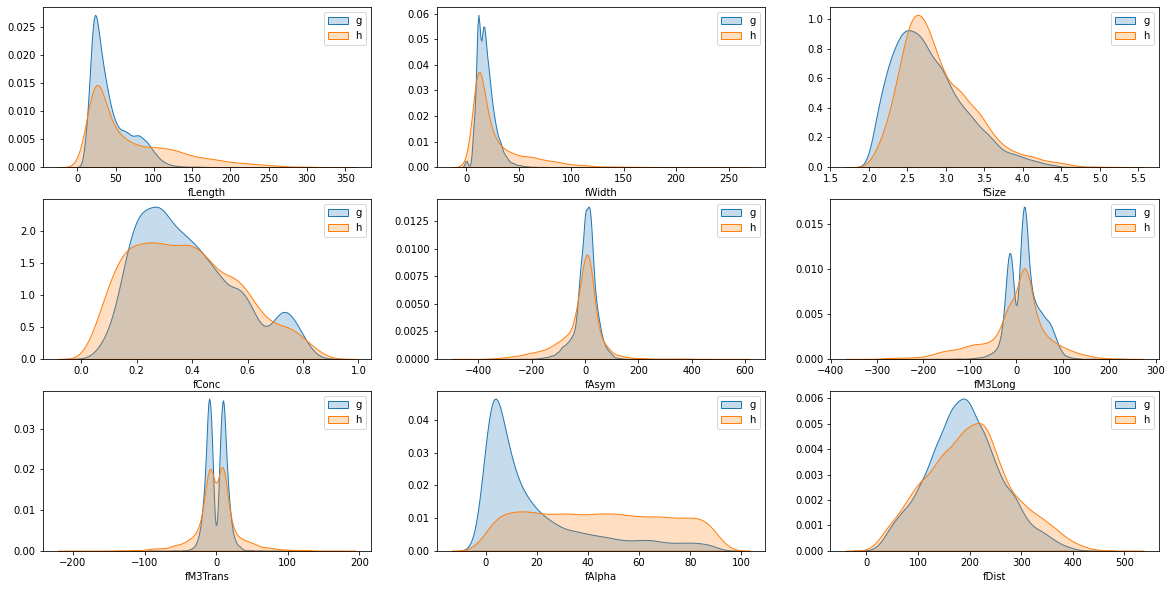

In [116]:
i=1
plt.figure(figsize=(20,10))
for col in dataset.columns:
    plt.subplot(3,3,i)
    sns.kdeplot(dataset.loc[(target=='g'),col],label='g',shade=True)
    sns.kdeplot(dataset.loc[(target=='h'),col],label='h',shade=True)
    plt.ylabel('')
    plt.legend()
    plt.tight_layout
    i+=1

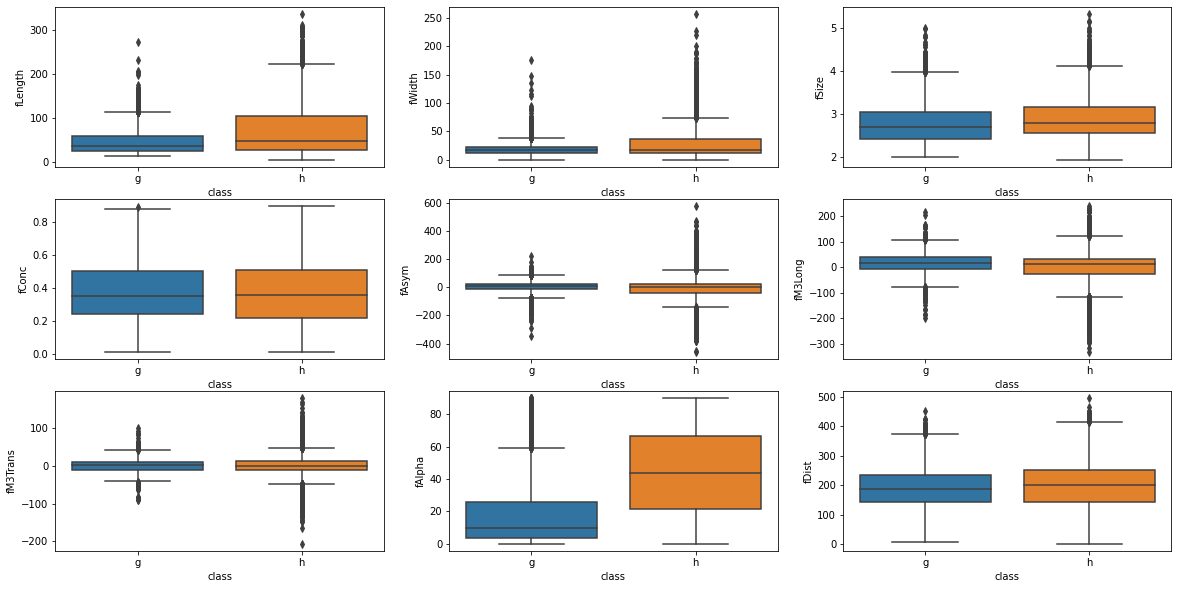

In [118]:
i=1
plt.figure(figsize=(20,10))
for col in dataset.columns:
    plt.subplot(3,3,i)
    ax = sns.boxplot(x=target, y=col, data=dataset,order=["g", "h"])
    plt.tight_layout
    i+=1

In [119]:
#Outlier detection
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
X_Q = dataset[~((dataset < (Q1 - 1.5 * IQR)) |(dataset > (Q3 + 1.5 * IQR))).any(axis=1)]
y_Q = target[~((dataset < (Q1 - 1.5 * IQR)) |(dataset > (Q3 + 1.5 * IQR))).any(axis=1)]

# Isolation forest

clf = IsolationForest()
is_outliers = clf.fit_predict(dataset)
X_IF = dataset.iloc[is_outliers==1]
y_IF = target.iloc[is_outliers==1]

In [120]:
data = X_IF
y = y_IF

In [121]:
# Scaling
# MinMaxScaler doesn’t reduce the importance of outliers

X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data))

In [147]:
# Dimensionality reduction
pca = PCA(0.95)
X_pca = pca.fit_transform(X)

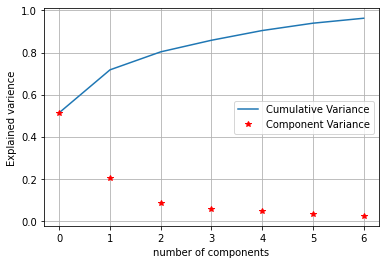

In [148]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot(pca.explained_variance_ratio_,'r*')
plt.xlabel('number of components')
plt.ylabel('Explained varience');
plt.legend(['Cumulative Variance', 'Component Variance'])
plt.grid()

In [190]:
def confmat(y_test,pred):
    cf_matrix = confusion_matrix(y_test, pred)
    ax = sns.heatmap(cf_matrix, annot=True,cmap=plt.cm.Blues,fmt='g',xticklabels=["g","h"],yticklabels=["g","h"]) #notation: "annot" not "annote"
   # bottom, top = ax.get_ylim()
   # ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set(xlabel='True Label', ylabel='Predicted Label')

In [160]:
# Label encoding categorical to nominal representation
y = pd.DataFrame(preprocessing.LabelEncoder().fit_transform(y))

In [161]:
# Train test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pca, y, test_size=0.30, random_state=42,stratify=y)

In [162]:
# Decision Tree Classifier

kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    #Classification
    clf = DecisionTreeClassifier(criterion='gini',max_depth=10)
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

mean score 0.624390042850299


In [200]:
# results on the test set
dtc = DecisionTreeClassifier(criterion='gini',max_depth=10)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
dtc.fit(X_res,y_res)
pred = dtc.predict(X_test)
print(accuracy_score(pred,y_test))
print(f1_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

0.7587649402390438
0.6320267395928291
0.7212205270457698
0.5624661979448351


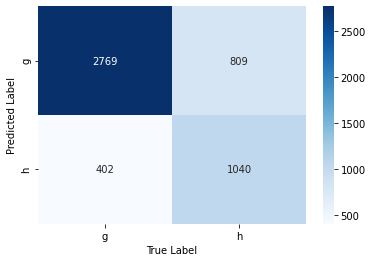

In [201]:
confmat(y_test,pred)

In [163]:
# Random forest classifier
kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    #Classification
    clf = RandomForestClassifier()
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

<ipython-input-163-2b3dc70fa8ad>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_res,y_res)
<ipython-input-163-2b3dc70fa8ad>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_res,y_res)
<ipython-input-163-2b3dc70fa8ad>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_res,y_res)
<ipython-input-163-2b3dc70fa8ad>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_res,y_res)
<ipython-input-163-2b3dc70fa8ad>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sha

mean score 0.6726534622066185


In [202]:
# results on the test set
rfc = RandomForestClassifier(n_estimators=300,max_depth=10, max_features = 'sqrt')
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
rfc.fit(X_res,y_res)
pred = rfc.predict(X_test)
print(accuracy_score(pred,y_test))
print(f1_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

<ipython-input-202-cb112df096ce>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_res,y_res)


0.7926294820717131
0.6727444199937127
0.7420249653259362
0.6152961472110409


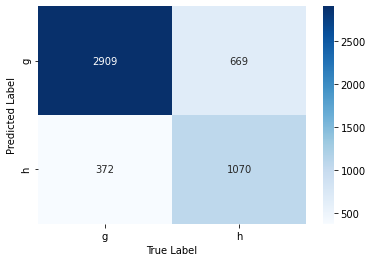

In [203]:
confmat(y_test,pred)

In [193]:
#Logistic regression classifier

kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    #Classification
    clf = LogisticRegression()
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConv

mean score 0.6160649240217881


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [204]:
lrc = LogisticRegression()
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
lrc.fit(X_res,y_res)
pred = lrc.predict(X_test)
print(accuracy_score(pred,y_test))
print(f1_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

0.7543824701195219
0.6179113727920669
0.6914008321775312
0.5585434173669468


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


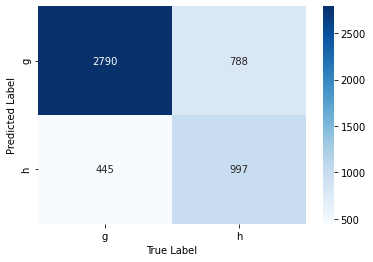

In [195]:
confmat(y_test,pred)

In [196]:
# SVM
kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    #Classification
    clf = LinearSVC()
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConv

mean score 0.61457404598585


In [222]:
# Results on the test set
clf = LinearSVC(C=1, max_iter=10000)
svm = CalibratedClassifierCV(clf) 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
svm.fit(X_res,y_res)
pred = svm.predict(X_test)
print(accuracy_score(pred,y_test))
print(f1_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7523904382470119
0.6162395801173202
0.6920943134535368
0.555370061213133


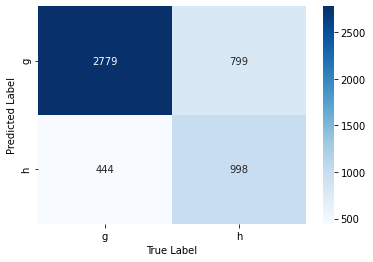

In [223]:
confmat(y_test,pred)

In [238]:
# K-nearest neighbours
kf = StratifiedKFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train_val,y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[test_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[test_index]
    
    #SMOTE
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    
    #Classification
    clf = KNeighborsClassifier(n_neighbors=10)
    clf.fit(X_res,y_res)
    pred = clf.predict(X_val)
    scores.append(f1_score(pred,y_val))
print(f"mean score {np.mean(scores)}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_cla

mean score 0.6258390522846577


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [239]:
# results on test data
knn = KNeighborsClassifier(n_neighbors=10)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_val, y_train_val)
knn.fit(X_res,y_res)
pred = knn.predict(X_test)
print(accuracy_score(pred,y_test))
print(f1_score(pred,y_test))
print(precision_score(pred,y_test))
print(recall_score(pred,y_test))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7808764940239044
0.644932214331827
0.6927877947295423
0.6032608695652174


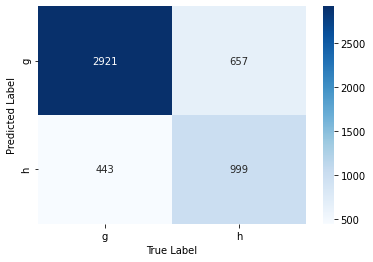

In [240]:
confmat(y_test,pred)

In [236]:
r_probs = [0 for _ in range(len(y_test))]
dtc_probs = dtc.predict_proba(X_test)
rfc_probs = rfc.predict_proba(X_test)
lrc_probs = lrc.predict_proba(X_test)
svm_probs = svm.predict_proba(X_test)
knn_probs = knn.predict_proba(X_test)

dtc_probs = dtc_probs[:, 1]
rfc_probs = rfc_probs[:, 1]
lrc_probs = lrc_probs[:, 1]
svm_probs = svm_probs[:, 1]
knn_probs = knn_probs[:, 1]


r_auc = roc_auc_score(y_test, r_probs)
dtc_auc = roc_auc_score(y_test, dtc_probs)
rfc_auc = roc_auc_score(y_test, rfc_probs)
lrc_auc = roc_auc_score(y_test, lrc_probs)
svm_auc = roc_auc_score(y_test, svm_probs)
knn_auc = roc_auc_score(y_test, svm_probs)

r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
dtc_fpr, dtc_tpr, _ = roc_curve(y_test, dtc_probs)
rfc_fpr, rfc_tpr, _ = roc_curve(y_test, rfc_probs)
lrc_fpr, lrc_tpr, _ = roc_curve(y_test, lrc_probs)
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_probs)
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)



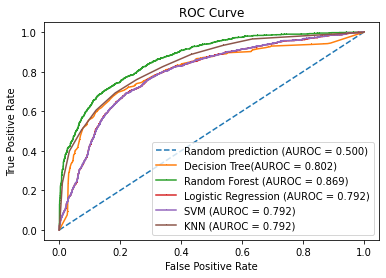

In [241]:
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(dtc_fpr, dtc_tpr, marker=',', label='Decision Tree(AUROC = %0.3f)' % dtc_auc)
plt.plot(rfc_fpr, rfc_tpr, marker=',', label='Random Forest (AUROC = %0.3f)' % rfc_auc)
plt.plot(lrc_fpr, lrc_tpr, marker=',', label='Logistic Regression (AUROC = %0.3f)' % lrc_auc)
plt.plot(svm_fpr, svm_tpr, marker=',', label='SVM (AUROC = %0.3f)' % svm_auc)
plt.plot(knn_fpr, knn_tpr, marker=',', label='KNN (AUROC = %0.3f)' % knn_auc)

# Title
plt.title('ROC Curve')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()